In [0]:
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [0]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 95% 257M/271M [00:02<00:00, 137MB/s]
100% 271M/271M [00:02<00:00, 120MB/s]
 99% 539M/544M [00:03<00:00, 118MB/s] 
100% 544M/544M [00:03<00:00, 150MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 96.5MB/s]


In [0]:
!unzip train.zip

In [0]:
!unzip test.zip

# Import Library

In [0]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./"))


['.config', 'kaggle.json', 'test', 'test.zip', 'train', 'train.zip', 'sample_submission.csv', 'sample_data']


# Define Constants

In [0]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# See sample image

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [0]:
train_filenames = os.listdir("./train")
test_filenames = os.listdir("./test")
filenames = os.listdir("./train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

filenames = os.listdir("./test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

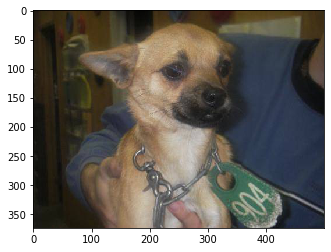

In [0]:
sample = random.choice(os.listdir("./train"))
image = load_img("./train/"+sample)
plt.imshow(image)

### Modelling

In [0]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications import VGG16

tmodel=VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
tmodel.summary()





58892288/58889256 [==============================] - 2s 0us/step






Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
____________________________________________________

In [0]:
targets=list()
full_paths=list()
FILE_NAMES = os.listdir("./train")

for file_name in FILE_NAMES:
    target=file_name.split(".")[0]
    full_path=os.path.join('./train/', file_name)
    full_paths.append(full_path)
    targets.append(target)

In [0]:
from keras.preprocessing.image import load_img, img_to_array
counter=0
features=list()
for path, target in zip(full_paths, targets):
    img=load_img(path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img=img_to_array(img)
    img=np.expand_dims(img, axis=0)
    feature= tmodel.predict(img)
    features.append(feature)
    counter+=1
    if counter%2500==0:
        print("[INFO]:{} images loaded".format(counter))

[INFO]:2500 images loaded
[INFO]:5000 images loaded
[INFO]:7500 images loaded
[INFO]:10000 images loaded
[INFO]:12500 images loaded
[INFO]:15000 images loaded
[INFO]:17500 images loaded
[INFO]:20000 images loaded
[INFO]:22500 images loaded
[INFO]:25000 images loaded


In [0]:
features=np.array(features)
print("Before reshape,features.shape:",features.shape)
features=features.reshape(features.shape[0], 4*4*512)
print("After reshape, features.shape:",features.shape)

Before reshape,features.shape: (25000, 1, 4, 4, 512)
After reshape, features.shape: (25000, 8192)


In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
le=LabelEncoder()
targets=le.fit_transform(targets)

In [0]:
print("features.shape:",features.shape)
print("targets.shape:",targets.shape)

features.shape: (25000, 8192)
targets.shape: (25000,)


In [0]:
# X_train, X_test, y_train, y_test=train_test_split(features, targets, test_size=0.2, random_state=42)
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
#df["category"] = df["category"].replace({'cat': 0, 'dog': 1}) 
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=20
)

Found 20000 validated image filenames belonging to 2 classes.


In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=20
)

Found 5000 validated image filenames belonging to 2 classes.


In [0]:
# Defining and training the densely connected classifier

# Freezing the conv base
tmodel.trainable = False


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import RMSprop

model = Sequential()
model.add(tmodel)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))


model.compile(optimizer = RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=40,
validation_data=validation_generator,
validation_steps=55)



Epoch 1/40
100/100 [==============================] - 15s 150ms/step - loss: 0.5792 - acc: 0.7010 - val_loss: 0.4356 - val_acc: 0.8327
Epoch 2/40
100/100 [==============================] - 13s 133ms/step - loss: 0.4642 - acc: 0.8025 - val_loss: 0.3837 - val_acc: 0.8373
Epoch 3/40
100/100 [==============================] - 13s 134ms/step - loss: 0.3900 - acc: 0.8330 - val_loss: 0.3592 - val_acc: 0.8555
Epoch 4/40
100/100 [==============================] - 14s 136ms/step - loss: 0.3685 - acc: 0.8415 - val_loss: 0.3289 - val_acc: 0.8627
Epoch 5/40
100/100 [==============================] - 13s 133ms/step - loss: 0.3445 - acc: 0.8495 - val_loss: 0.2980 - val_acc: 0.8682
Epoch 6/40
100/100 [==============================] - 13s 133ms/step - loss: 0.3460 - acc: 0.8520 - val_loss: 0.3054 - val_acc: 0.8627
Epoch 7/40
100/100 [==============================] - 13s 132ms/step - loss: 0.3384 - acc: 0.8455 - val_loss: 0.2759 - val_acc: 0.8918
Epoch 8/40
100/100 [==============================] -

<Figure size 432x288 with 0 Axes>

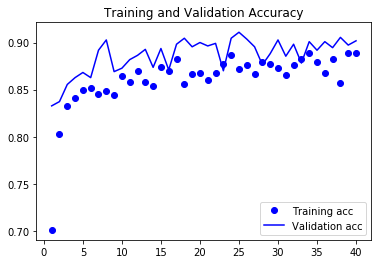

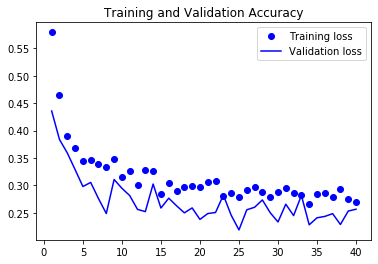

<Figure size 432x288 with 0 Axes>

In [0]:

# Plotting the results of the new network

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

In [0]:

tmodel.trainable = True
set_trainable = False

for layer in tmodel.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable == True
    else:
        layer.trainable == False

In [0]:
model.compile(
loss='binary_crossentropy',
optimizer=RMSprop(lr=1e-5),
metrics=['acc'])

history = model.fit_generator(
train_generator,
epochs=30,
steps_per_epoch=100,
validation_data=validation_generator,
validation_steps=50)

Epoch 1/30
100/100 [==============================] - 16s 163ms/step - loss: 0.2518 - acc: 0.8875 - val_loss: 0.1560 - val_acc: 0.9350
Epoch 2/30
100/100 [==============================] - 14s 144ms/step - loss: 0.2118 - acc: 0.9175 - val_loss: 0.1385 - val_acc: 0.9420
Epoch 3/30
100/100 [==============================] - 14s 144ms/step - loss: 0.1744 - acc: 0.9330 - val_loss: 0.1403 - val_acc: 0.9560
Epoch 4/30
100/100 [==============================] - 14s 144ms/step - loss: 0.1776 - acc: 0.9275 - val_loss: 0.1148 - val_acc: 0.9550
Epoch 5/30
100/100 [==============================] - 14s 145ms/step - loss: 0.1522 - acc: 0.9425 - val_loss: 0.1022 - val_acc: 0.9640
Epoch 6/30
100/100 [==============================] - 14s 144ms/step - loss: 0.1334 - acc: 0.9430 - val_loss: 0.1517 - val_acc: 0.9460
Epoch 7/30
100/100 [==============================] - 14s 145ms/step - loss: 0.1305 - acc: 0.9500 - val_loss: 0.1047 - val_acc: 0.9580
Epoch 8/30
100/100 [==============================] - 1

<Figure size 432x288 with 0 Axes>

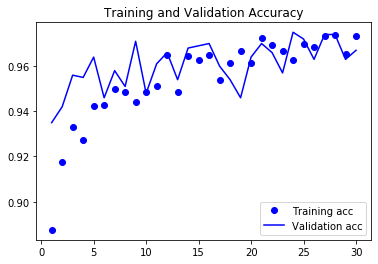

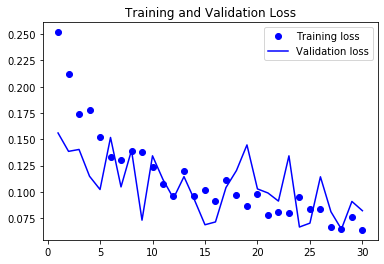

<Figure size 432x288 with 0 Axes>

In [0]:

# Plotting the results of the new network

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

In [0]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=20,
    shuffle=False
)

Found 12500 validated image filenames.


In [0]:
test_df['label'] = model.predict(test_generator).reshape(-1)

In [0]:
test_df.head()

,filename,label
0,2404.jpg,0.999990
1,1552.jpg,0.000002
2,10095.jpg,0.000000
3,4902.jpg,0.999994
4,7722.jpg,0.998819


In [0]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['label']
submission_df.drop(['filename'], axis=1, inplace=True)
submission_df.to_csv('submission_7.csv', index=False)

In [0]:
files.download('submission_7.csv') 



### See predicted result with images

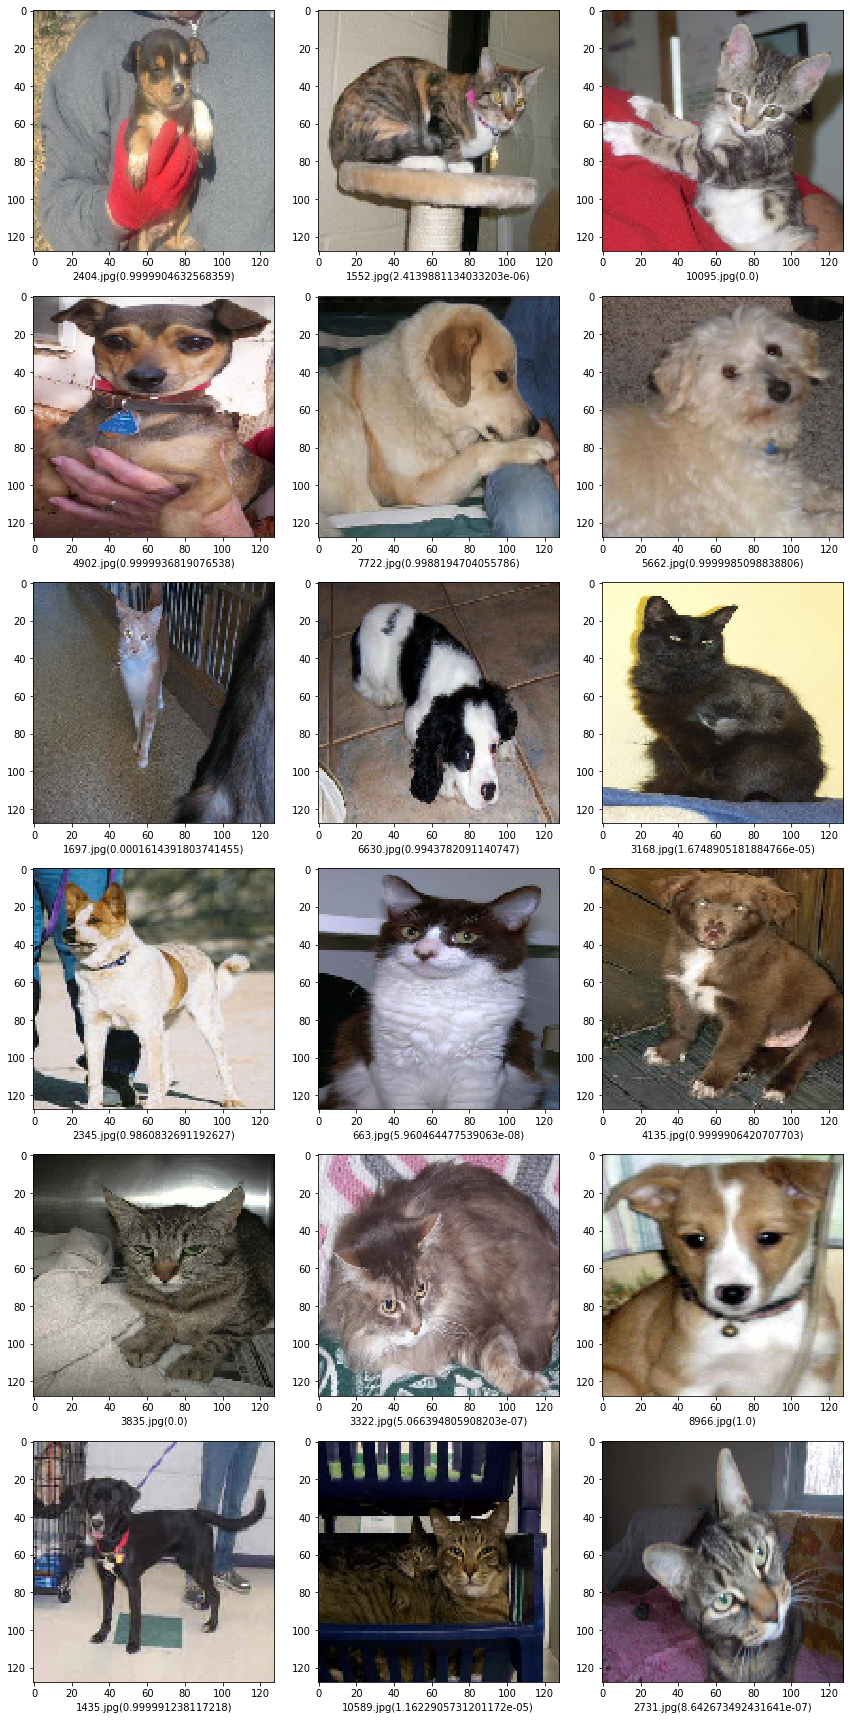

In [0]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['label']

    img = load_img("./test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()